In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import hipp
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import json
import numpy as np
import math
from collections import defaultdict

In [31]:
# open the dataframe of the detection
df_detected = pd.read_pickle("df_detected.pkl")

# process the dataframe to match the type of the new hipp
positions = hipp.aerial.Fiducials.corners_label + hipp.aerial.Fiducials.midsides_label + ["principal_point"]
detected_fiducials_1 = {}

for _, row in df_detected.iterrows():
    detected_fiducials_1[row["fileName"]] = {}
    for position in positions:
        if np.isnan(row[position+"_x"]) and np.isnan(row[position+"_y"]):
            detected_fiducials_1[row["fileName"]][position] = None
        else:
            detected_fiducials_1[row["fileName"]][position] = (row[position+"_x"], row[position+"_y"]) 

# open the detection if the new hipp
with open("detected_fiducials.json", "r", encoding="utf-8") as f:
    detected_fiducials_2 = json.load(f)

# align key to keep only id
detected_fiducials_1 = {os.path.basename(key):value for key, value in detected_fiducials_1.items()}
detected_fiducials_2 = {os.path.basename(key):value for key, value in detected_fiducials_2.items()}


In [46]:
def distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

distances = defaultdict(dict)  
none_values = defaultdict(lambda: defaultdict(list))

for key in detected_fiducials_1:
    for position in detected_fiducials_1[key]:
        p1 = detected_fiducials_1[key][position]
        p2 = detected_fiducials_2[key][position]
        if p1 is None:
            none_values["method_1"][key].append(position)
        if p2 is None:
            none_values["method_2"][key].append(position)
        if p1 is None or p2 is None:
            distances[position][key] = float('nan')
        else:
            distances[position][key] = distance(p1, p2)

df_distances = pd.DataFrame(distances)
df_none_values = pd.DataFrame(none_values)


/tmp/ipykernel_24039/1043304389.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_by_position, labels=df_distances.columns)
/tmp/ipykernel_24039/1043304389.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_by_key, labels=df_distances.index)


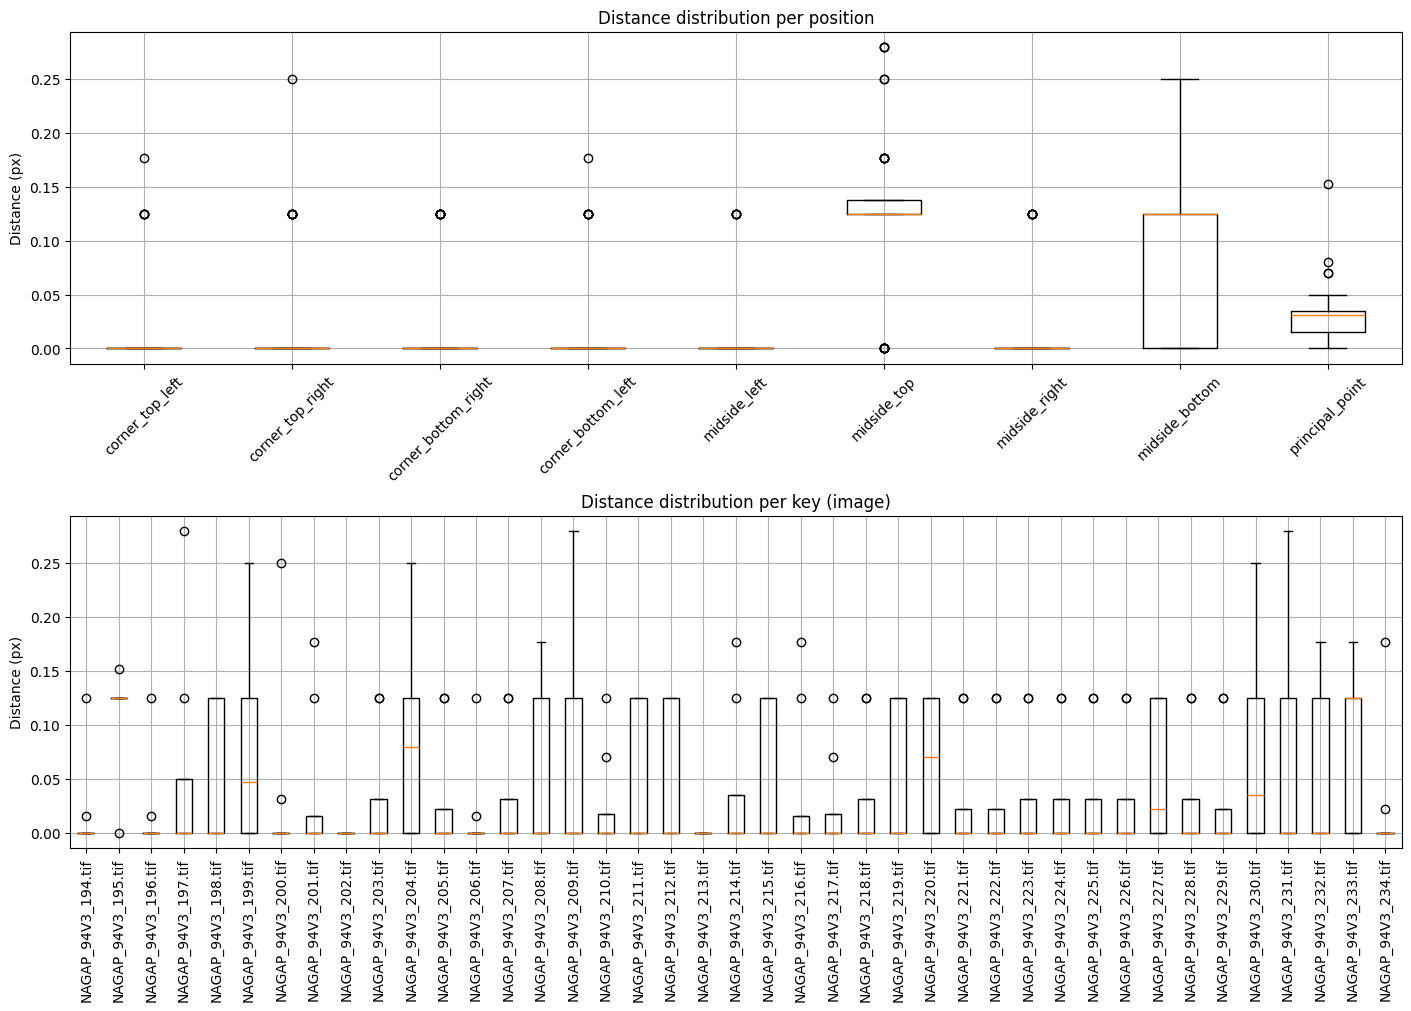

In [47]:
data_by_position = [df_distances[col].dropna().values for col in df_distances.columns]
data_by_key = [df_distances.loc[key].dropna().values for key in df_distances.index]


# -- Figure --
fig, axes = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

# Boxplot par position
axes[0].boxplot(data_by_position, labels=df_distances.columns)
axes[0].set_title("Distance distribution per position")
axes[0].set_ylabel("Distance (px)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Boxplot par clé
axes[1].boxplot(data_by_key, labels=df_distances.index)
axes[1].set_title("Distance distribution per key (image)")
axes[1].set_ylabel("Distance (px)")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

# Afficher
plt.show()

In [50]:
df_none_values

,method_1,method_2
NAGAP_94V3_195.tif,"[corner_top_left, corner_bottom_left, midside_...","[corner_top_left, corner_bottom_left, midside_..."
NAGAP_94V3_210.tif,[midside_right],[midside_right]
NAGAP_94V3_217.tif,[midside_top],NaN
NAGAP_94V3_220.tif,[corner_bottom_left],NaN


As we can see, there is only a small difference between the two algorithms — around 0.05 pixels. This indicates that both methods detect the fiducial markers at essentially the same locations.

It's interesting to observe the differences between the two methods. Both successfully remove incorrect detections, but the method based solely on the matching score also eliminates some correct detections when the fiducial markers are too noisy. This behavior is visible in the plot below, particularly for frame 217 (midside_top) and frame 220 (corner_bottom_left). In contrast, the second approach — which also considers angles — retains these detections. Cause the 90° degree angle is respected.

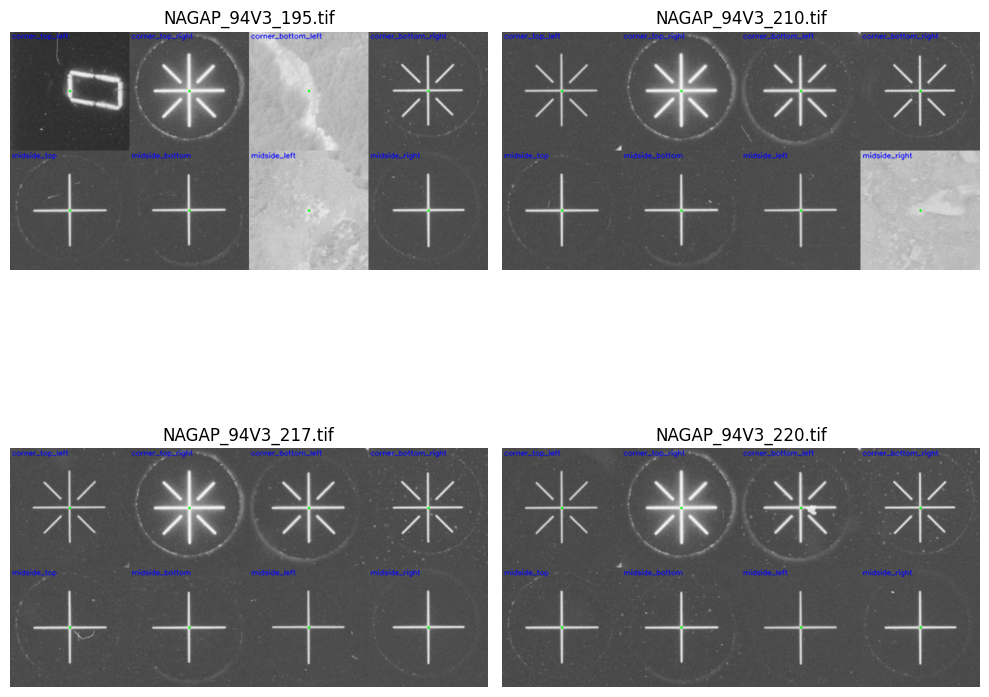

In [51]:
individuals_qc = "../fiducials_preproc/preprocessing/qc/fiducials_detection/individuals"
all_keys = list(df_none_values.index)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, key in zip(axes.ravel(), all_keys):
    qc_img_path = os.path.join(individuals_qc, os.path.basename(key).replace(".tif",".png"))
    qc_img = cv2.imread(qc_img_path)

    qc_img_rgb = cv2.cvtColor(qc_img, cv2.COLOR_BGR2RGB)
    ax.imshow(qc_img_rgb)
    ax.set_title(os.path.basename(key))
    ax.axis("off")

plt.tight_layout()
plt.show()